<a href="https://colab.research.google.com/github/bekucukakin/eye-disease-classification/blob/main/eye_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive (optional, for saving files)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install Kaggle to download datasets
!pip install -q kaggle

# Upload the kaggle.json API key file
from google.colab import files
files.upload()

# Configure Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (2).json


In [ ]:
# Download the Eye Disease dataset from Kaggle
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification
!unzip -q eye-diseases-classification.zip -d /content/eye_disease_dataset


Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
eye-diseases-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/eye_disease_dataset/dataset/cataract/0_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
N
n


In [ ]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Image preprocessing and model utilities
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Train-Test Split – Organize the Dataset Structure

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_dir = '/content/eye_disease_dataset/dataset'
target_dir = '/content/split_eye_disease_dataset'

os.makedirs(f'{target_dir}/train', exist_ok=True)
os.makedirs(f'{target_dir}/test', exist_ok=True)

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
        train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(f'{target_dir}/train/{class_name}', exist_ok=True)
        os.makedirs(f'{target_dir}/test/{class_name}', exist_ok=True)

        for img in train_imgs:
            shutil.copy(img, f'{target_dir}/train/{class_name}')
        for img in test_imgs:
            shutil.copy(img, f'{target_dir}/test/{class_name}')



Prepare Image Data Generators for Training, Validation, and Testing


In [ ]:

# Define training and testing directories
train_dir = '/content/split_eye_disease_dataset/train'
test_dir = '/content/split_eye_disease_dataset/test'


# Image data generator for training with 20% validation split
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=32,
    class_mode='categorical', subset='training'
)

# Load validation data
val_data = train_datagen.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=32,
    class_mode='categorical', subset='validation'
)

# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir, target_size=(150,150), batch_size=32,
    class_mode='categorical', shuffle=False
)


Found 2699 images belonging to 4 classes.
Found 673 images belonging to 4 classes.
Found 845 images belonging to 4 classes.


Build and Compile a Custom CNN Model

In [ ]:
custom_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Train the Custom CNN Model

In [ ]:
history_custom = custom_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.4711 - loss: 1.1662 - val_accuracy: 0.5349 - val_loss: 0.9532
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.6652 - loss: 0.7753 - val_accuracy: 0.6107 - val_loss: 0.8054
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.7795 - loss: 0.5670 - val_accuracy: 0.5334 - val_loss: 1.1255
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.7983 - loss: 0.5033 - val_accuracy: 0.5305 - val_loss: 1.0551
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8141 - loss: 0.4610 - val_accuracy: 0.5305 - val_loss: 1.1432
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8263 - loss: 0.4206 - val_accuracy: 0.5736 - val_loss: 0.8813
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.8471 - loss: 0.3988 - val_accuracy: 0.5349 - val_loss: 1.0602
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8551 - loss: 0.3653 - val_accuracy: 0.5364 - v

Transfer Learning with MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')
base_model.trainable = False  # İlk başta sadece top layers eğitilecek

transfer_model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()


<ipython-input-51-f7ffe51ce019>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Transfer Learning Mode

In [ ]:
history_transfer = transfer_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.6312 - loss: 0.9256 - val_accuracy: 0.7296 - val_loss: 0.6944
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8094 - loss: 0.4882 - val_accuracy: 0.6850 - val_loss: 0.7665
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 135s 995ms/step - accuracy: 0.8420 - loss: 0.4085 - val_accuracy: 0.7816 - val_loss: 0.5977
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8658 - loss: 0.3494 - val_accuracy: 0.7474 - val_loss: 0.6808
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8744 - loss: 0.3437 - val_accuracy: 0.7474 - val_loss: 0.6509
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 84s 984ms/step - accuracy: 0.8737 - loss: 0.3260 - val_accuracy: 0.7385 - val_loss: 0.7302
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 988ms/step - accuracy: 0.8874 - loss: 0.2824 - val_accuracy: 0.7533 - val_loss: 0.6609
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 964ms/step - accuracy: 0.8905 - loss: 0.3079 - val_accuracy: 0.76

Training Graphs


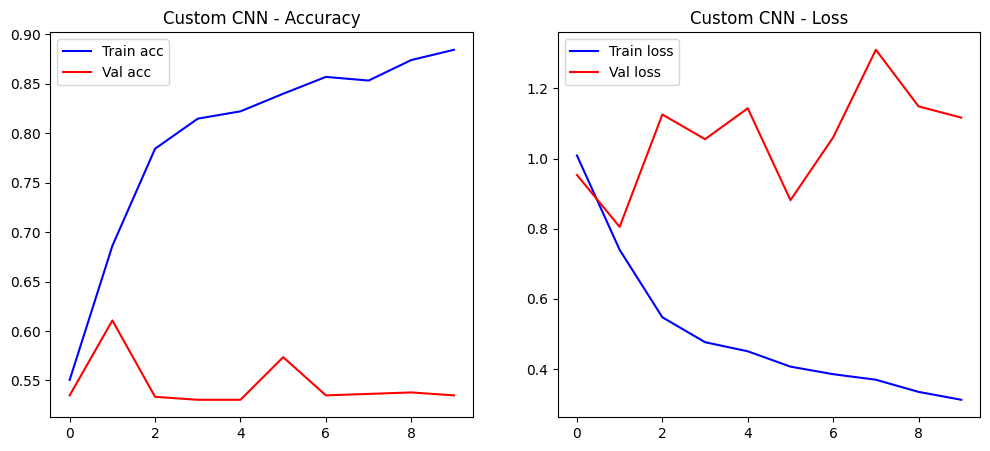

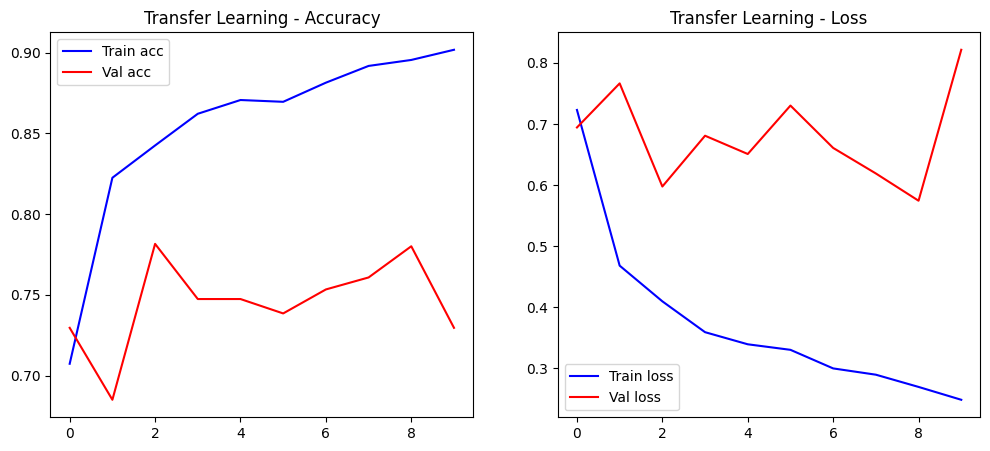

In [ ]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Train acc')
    plt.plot(epochs, val_acc, 'r', label='Val acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Train loss')
    plt.plot(epochs, val_loss, 'r', label='Val loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

plot_history(history_custom, "Custom CNN")
plot_history(history_transfer, "Transfer Learning")


Test Sonuçları, Confusion Matrix, Precision/Recall/F1


27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
Classification Report for Custom CNN
                      precision    recall  f1-score   support

            cataract       0.87      0.67      0.76       208
diabetic_retinopathy       1.00      0.99      1.00       220
            glaucoma       0.87      0.61      0.72       202
              normal       0.65      0.98      0.78       215

            accuracy                           0.82       845
           macro avg       0.85      0.81      0.81       845
        weighted avg       0.85      0.82      0.82       845



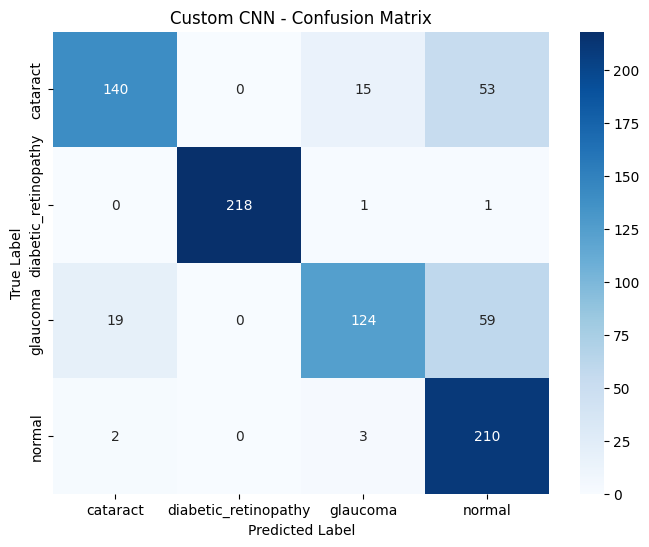

27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 855ms/step
Classification Report for Transfer Learning
                      precision    recall  f1-score   support

            cataract       0.95      0.88      0.91       208
diabetic_retinopathy       0.99      0.87      0.93       220
            glaucoma       0.83      0.71      0.76       202
              normal       0.70      0.93      0.80       215

            accuracy                           0.85       845
           macro avg       0.87      0.85      0.85       845
        weighted avg       0.87      0.85      0.85       845



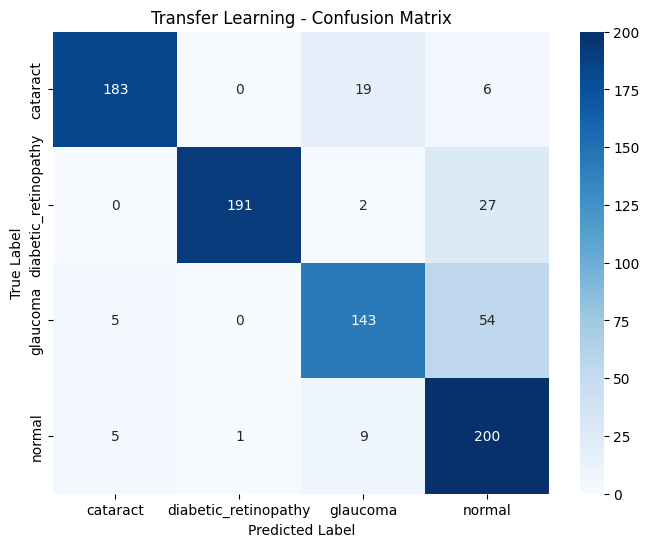

In [ ]:
def evaluate_model(model, test_data, name):
    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_data.classes
    class_labels = list(test_data.class_indices.keys())

    print(f"Classification Report for {name}")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

evaluate_model(custom_model, test_data, "Custom CNN")
evaluate_model(transfer_model, test_data, "Transfer Learning")


Rastgele 3 Test Görüntüsü ve Tahmin

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


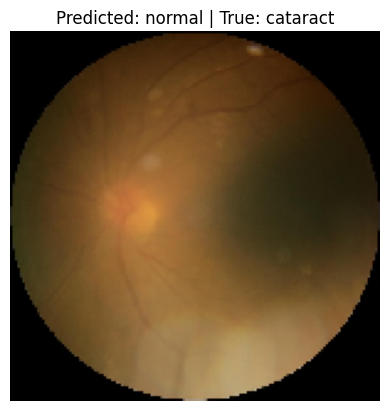

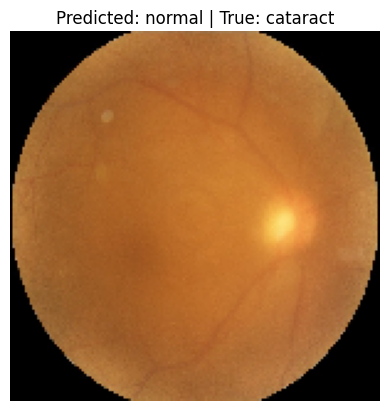

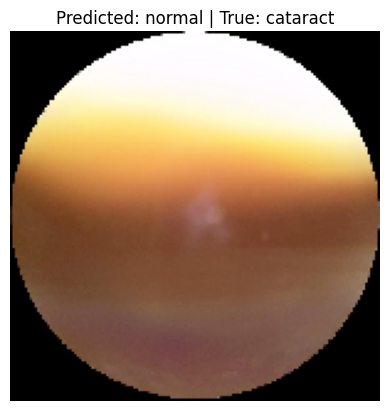

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


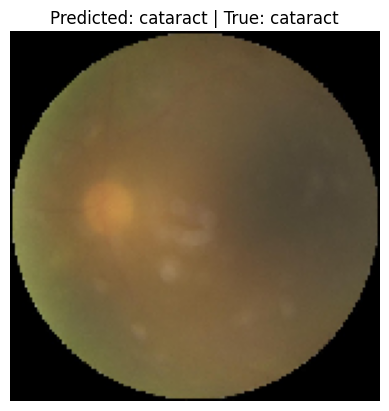

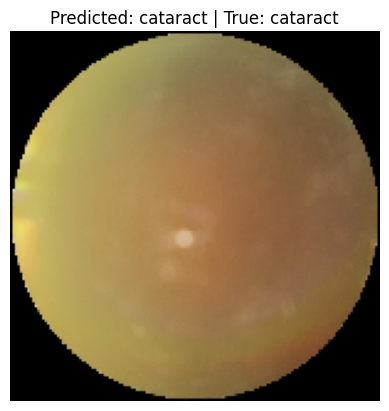

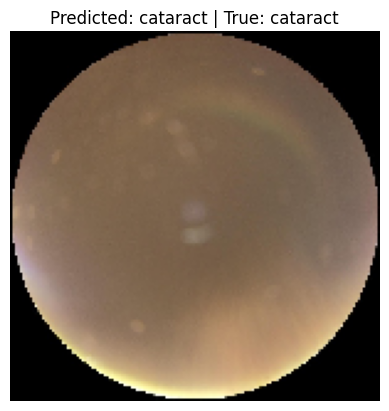

In [ ]:
def predict_sample_images(model, test_data):
    x, y = next(test_data)
    preds = model.predict(x)
    for i in range(3):
        plt.imshow(x[i])
        plt.title(f"Predicted: {test_data.class_indices_inv[np.argmax(preds[i])]} | True: {test_data.class_indices_inv[np.argmax(y[i])]}")
        plt.axis('off')
        plt.show()

# Invert class_indices for labeling
test_data.class_indices_inv = {v: k for k, v in test_data.class_indices.items()}
predict_sample_images(custom_model, test_data)
predict_sample_images(transfer_model, test_data)


In [120]:
!cd /content/drive/MyDrive/ColabNotebooks










/bin/bash: line 1: cd: /content/drive/MyDrive/ColabNotebooks: No such file or directory
